In [1]:
from google.colab import drive

from constants.date_time import DatetimeFreq

drive.mount('/content/gdrive')
% cd / content / gdrive / My\ Drive / masters

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/masters


In [2]:
% ls./ data / processed

T12H-X850M-Y880M_2013-01-01_2017-01-01/
T1H-X1700M-Y1760M_2013-01-01_2017-01-01/
T24H-X255M-Y220M_2013-01-01_2017-01-01/
T24H-X425M-Y440M_2013-01-01_2017-01-01/
T24H-X850M-Y880M_2013-01-01_2017-01-01/
T24H-X85M-Y110M_2013-01-01_2017-01-01/
T3H-X850M-Y880M_2013-01-01_2017-01-01/
T6H-X850M-Y880M_2013-01-01_2017-01-01/


In [0]:
import matplotlib.pyplot as plt
% matplotlib inline
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.metrics import best_threshold
from utils.utils import write_json, Timer
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import (PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred,
    get_y_pred_by_thresholds, best_thresholds)
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths
from models.model_result import (save_metrics, save_results, compare_models, compare_all_models, get_metrics_table,
    get_models_metrics, get_models_results)
from models.st_resnet_models import STResNet, STResNetExtra
from models.st_resnet_models import train_epoch_for_st_res_net, train_epoch_for_st_res_net_extra
from models.st_resnet_models import evaluate_st_res_net, evaluate_st_res_net_extra
import pandas as pd
from pprint import pprint

pd.set_option('display.max_columns', None)

In [0]:
data_sub_paths = get_data_sub_paths()
pprint(data_sub_paths)
data_sub_path = 'T1H-X1700M-Y1760M_2013-01-01_2017-01-01'

['T24H-X850M-Y880M_2013-01-01_2017-01-01',
 'T24H-X425M-Y440M_2013-01-01_2017-01-01',
 'T24H-X255M-Y220M_2013-01-01_2017-01-01',
 'T24H-X85M-Y110M_2013-01-01_2017-01-01',
 'T12H-X850M-Y880M_2013-01-01_2017-01-01',
 'T6H-X850M-Y880M_2013-01-01_2017-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2017-01-01',
 'T3H-X850M-Y880M_2013-01-01_2017-01-01']


## Load data

In [0]:
USE_EXTRA = False  # todo move extra model to own notebook

conf = BaseConf()

if USE_EXTRA:
    conf.model_name = "ST-RESNET-Extra"  # needs to be created
else:
    conf.model_name = "ST-RESNET"  # needs to be created

conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
torch.manual_seed(conf.seed)
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-12-01T13:50:28 | root | INFO | =====================================BEGIN=====================================
2019-12-01T13:50:28 | root | INFO | Device: cuda:0


In [0]:
conf.batch_size = 32

# CRIME DATA
data_group = GridDataGroup(data_path=conf.data_path,
                           conf=conf)

loaders = GridDataLoaders(data_group=data_group,
                          conf=conf)

2019-12-01T13:50:31 | root | INFO | 	t_range shape (35065,)


## Model setup

In [0]:
# SET THE hyperparameterS
conf.dropout = 0  #0.2
conf.weight_decay = 1e-8
conf.lr = 1e-3

conf.checkpoint = "best"  # "latest" #
conf.resume = False
conf.freqstr = DatetimeFreq.convert(data_group.t_range)
conf.early_stopping = False
conf.max_epochs = 30

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.MSELoss()

# SETUP MODEL
dataset = loaders.train_loader.dataset
_, h_size, w_size = dataset.crimes.shape
_, n_ext_features = dataset.time_vectors.shape

# todo setup - hyper-optimiser
conf.n_layers = 12  # number of res-unit layers
conf.n_channels = 5  # inner channel size of the res-units

if USE_EXTRA:
    train_epoch_fn = train_epoch_for_st_res_net_extra
    evaluate_fn = evaluate_st_res_net_extra
    model = STResNetExtra(n_layers=conf.n_layers,
                          n_channels=conf.n_channels,
                          y_size=h_size,
                          x_size=w_size,

                          lc=dataset.n_steps_c,
                          lp=dataset.n_steps_p,
                          lq=dataset.n_steps_q,

                          n_ext_features=n_ext_features,
                          n_demog_features=37,
                          n_demog_channels=10,
                          n_demog_layers=3,

                          n_gsv_features=512,
                          n_gsv_channels=10,
                          n_gsv_layers=3)
else:
    train_epoch_fn = train_epoch_for_st_res_net
    evaluate_fn = evaluate_st_res_net
    model = STResNet(n_layers=conf.n_layers,
                     n_channels=conf.n_channels,
                     y_size=h_size,
                     x_size=w_size,

                     lc=dataset.n_steps_c,
                     lp=dataset.n_steps_p,
                     lq=dataset.n_steps_q,

                     n_ext_features=n_ext_features)

# todo implement model_arch for res-net
model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()
# todo (optional): setup model parameters dynamically 

optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

if conf.resume:
    try:
        # resume from previous check point or resume from best validation score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)

        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict)

        # new optimiser hyperparameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")


## Training loop

2019-12-01T14:14:58 | root | INFO | lr: 		0.001
2019-12-01T14:14:58 | root | INFO | weight_decay: 	1e-08
2019-12-01T14:14:58 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-12-01T14:14:58 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 32,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2017-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.001,
 'max_epochs': 30,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2017-01-01/models/ST-RESNET/',
 'n_channels': 5,
 'n_layers': 12,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'pad_width': 0,
 'resume': False,
 'seed': 3,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': False,
 'sub_sample_test_set': 0,
 'sub_sample_train_set': 1,
 'sub_sample

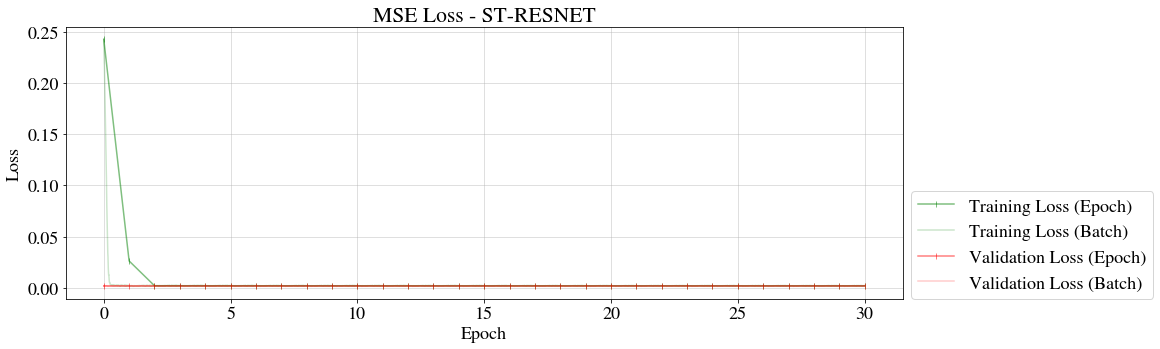

In [0]:
log.info(f"lr: \t\t{optimiser.param_groups[0]['lr']}")
log.info(f"weight_decay: \t{optimiser.param_groups[0]['weight_decay']}")
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                                optimiser=optimiser,
                                                                loaders=loaders,
                                                                train_epoch_fn=train_epoch_fn,
                                                                loss_fn=loss_function,
                                                                conf=conf)

log.info(f"stopped_early: {stopped_early}")  # use the current epoch instead
# if stopped_early -> continue with best_model - new hyperparameters -> no n 

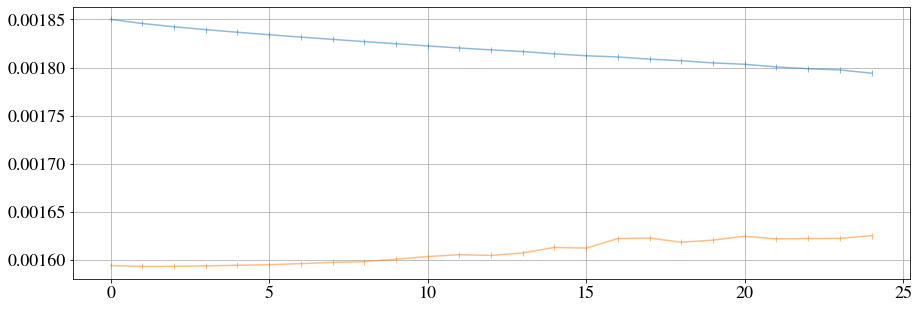

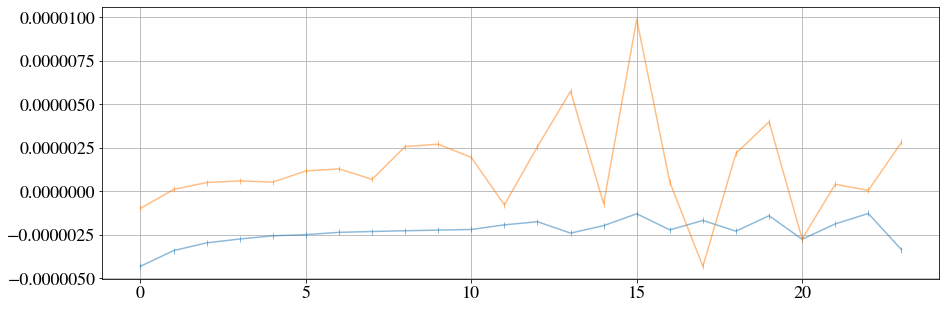

In [0]:
lim = 25

plt.figure(figsize=(15, 5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(x[-lim:], marker='|', alpha=.5)

plt.grid()
plt.show()

plt.figure(figsize=(15, 5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(np.diff(x[-lim:]), marker='|', alpha=.5)

plt.grid()
plt.show()

## Evaluation

In [0]:
# Load latest or best validation model
conf.checkpoint = "latest"
# conf.checkpoint = "best"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validation score checkpoint
# load model state
log.info(f"loading model from {conf.model_path}")
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                              map_location=conf.device.type)
model.load_state_dict(model_state_dict)

2019-12-01T14:33:48 | root | INFO | Loading model from checkpoint (latest) for evaluation
2019-12-01T14:33:48 | root | INFO | loading model from ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2017-01-01/models/ST-RESNET/


<All keys matched successfully>

In [0]:
trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                     batch_loader=loaders.train_loader,
                                                                     conf=conf)
thresh = best_threshold(y_class=trn_y_true,
                        y_score=trn_probas_pred)

tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                                     batch_loader=loaders.test_loader,
                                                                     conf=conf)

tst_y_true = np.expand_dims(tst_y_true, axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)

tst_y_true = data_group.shaper.squeeze(tst_y_true)
tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)

tst_y_pred = get_y_pred(thresh, tst_probas_pred)
save_metrics(y_count=tst_y_true,
             y_pred=tst_y_pred,
             y_score=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,
             conf=conf)

save_results(y_count=tst_y_true,
             y_pred=tst_y_pred,
             y_score=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,
             conf=conf)

2019-12-01T14:33:54 | root | INFO | f1_score: 0.3546759037115128 at index 1470141, new threshold 0.03320930525660515


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-12-01T14:34:07 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                MAE:                0.11469801464794852
                RMSE:               0.3079854950362726
                ROC AUC:            0.7339616148482664                
                Average Precision:  0.2333818340336019
                Precision:          0.2292670499230164
                Recall:             0.44114324687226925
                Accuracy:           0.7930873615301712
                MCC:                0.2086392178637034          
        
2019-12-01T14:34:07 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7339616148482664
                Average Precision:  0.2333818340336019                
                Precision:          0.2292670499230164
                Recall:             0.44114324687226925
                Accuracy:           0.7930873615301712
                MCC:                0.20863921

```
BEST
2019-12-01T11:34:40 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                MAE:                0.11235767304386506
                RMSE:               0.3086258487006532
                ROC AUC:            0.7420039865152315                
                Average Precision:  0.24622740566399162
                Precision:          0.23683428860603528
                Recall:             0.4588333084677849
                Accuracy:           0.7953335478729263
                MCC:                0.2219225157523026          
        
2019-12-01T11:34:40 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7420039865152315
                Average Precision:  0.24622740566399162                
                Precision:          0.23683428860603528
                Recall:             0.4588333084677849
                Accuracy:           0.7953335478729263
                MCC:                0.2219225157523026
```

2019-12-01T14:34:11 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.307219  0.115530  0.747916        0.251100   0.237131   
Ind-Hawkes Model      0.303955  0.120553  0.734573        0.242240   0.221675   
ST-RESNET             0.307985  0.114698  0.733962        0.233382   0.229267   
Hawkes General Model  0.308475  0.115534  0.720364        0.225143   0.206355   
Global Average        0.308343  0.116342  0.726534        0.218657   0.202823   
Previous Time Step    0.312521  0.114004  0.548897        0.119208   0.188911   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.471088  0.315466  0.792826           0.225921  
Ind-Hawkes Model      0.497069  0.306612  0.772178           0.216239  
ST-RESNET             0.44

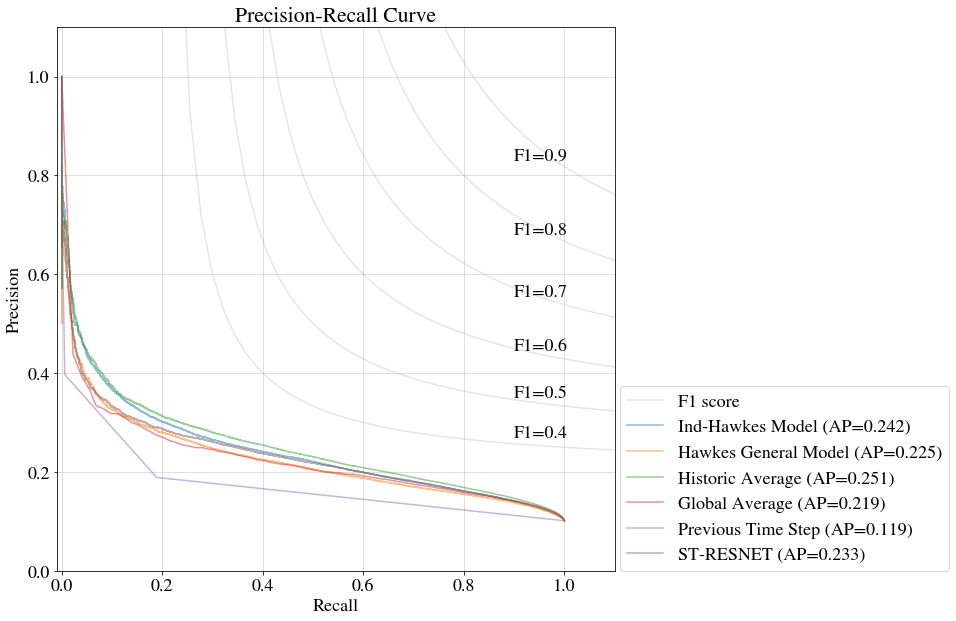

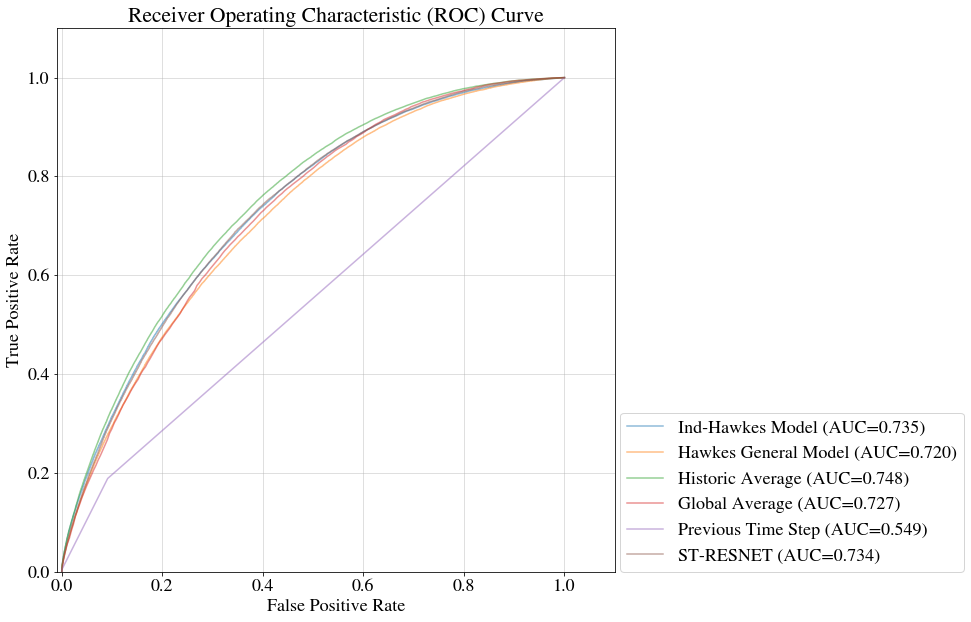

,RMSE,MAE,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
Model Name,,,,,,,,,
Historic Average,0.307219,0.115530,0.747916,0.251100,0.237131,0.471088,0.315466,0.792826,0.225921
Ind-Hawkes Model,0.303955,0.120553,0.734573,0.242240,0.221675,0.497069,0.306612,0.772178,0.216239
ST-RESNET,0.307985,0.114698,0.733962,0.233382,0.229267,0.441143,0.301725,0.793087,0.208639
Hawkes General Model,0.308475,0.115534,0.720364,0.225143,0.206355,0.496622,0.291561,0.755438,0.197643
Global Average,0.308343,0.116342,0.726534,0.218657,0.202823,0.508152,0.289925,0.747766,0.196177
Previous Time Step,0.312521,0.114004,0.548897,0.119208,0.188911,0.188879,0.188895,0.835627,0.097441


In [0]:
compare_all_models(conf.data_path)


In [0]:

models_metrics = get_models_metrics(data_path=conf.data_path)

get_metrics_table(models_metrics)

In [0]:
models_results = get_models_results(data_path=conf.data_path)

In [0]:
m = models_results[0].probas_pred



(399, 1, 702)

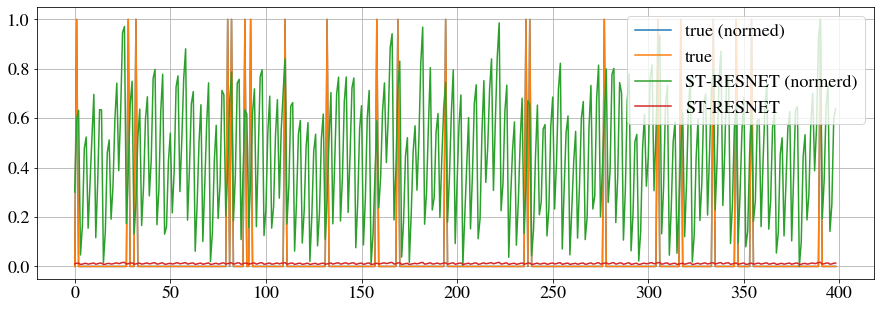

In [0]:
m = models_results[0]


def norm(x):
    #     return x
    x = x - np.min(x)
    x = x / np.max(x)
    return x


i = 0
lim = 400
for m in models_results:
    plt.figure(figsize=(15, 5))

    y_true = m.y_true[:lim, 0, i]  #.sum(1)
    plt.plot(norm(y_true), label='true (normed)')
    plt.plot(y_true, label='true')

    x0 = m.probas_pred[:lim, 0, i]  #.sum(1)
    plt.plot(norm(x0), label=f"{m.model_name} (normerd)")
    plt.plot(x0, label=m.model_name)

    plt.grid()
    plt.legend()
    plt.show()


In [0]:
m = models_results[1]
m.y_true.shape

(99, 1, 4935)

In [0]:
targets = [m.shaper for m in models_results]
for t in targets:
    print(t.l)

4935
4935
4935
4935
4935
4935


----------------------------------------------------------------------------------------------------

## All in one

In [1]:
import matplotlib.pyplot as plt
% matplotlib inline
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths
from models.model_result import save_metrics, compare_models, get_models_metrics, get_models_results, compare_all_models
from models.st_resnet_models import STResNet, STResNetExtra
from models.st_resnet_models import train_epoch_for_st_res_net, train_epoch_for_st_res_net_extra
from models.st_resnet_models import evaluate_st_res_net, evaluate_st_res_net_extra
from pprint import pprint

In [6]:
data_sub_paths = get_data_sub_paths()
pprint(data_sub_paths)

data_sub_paths = [
    'T24H-X850M-Y880M_2013-01-01_2017-01-01',
    # 'T24H-X425M-Y440M_2013-01-01_2017-01-01',
    # 'T24H-X255M-Y220M_2013-01-01_2017-01-01',  # not enough gpu ram
    # 'T24H-X85M-Y110M_2013-01-01_2017-01-01',
    #     'T12H-X850M-Y880M_2013-01-01_2017-01-01',
    #     'T6H-X850M-Y880M_2013-01-01_2017-01-01',
    #     'T1H-X1700M-Y1760M_2013-01-01_2017-01-01',
    #     'T3H-X850M-Y880M_2013-01-01_2017-01-01'
]

['T24H-X850M-Y880M_2013-01-01_2017-01-01',
 'T24H-X425M-Y440M_2013-01-01_2017-01-01',
 'T24H-X255M-Y220M_2013-01-01_2017-01-01',
 'T24H-X85M-Y110M_2013-01-01_2017-01-01',
 'T12H-X850M-Y880M_2013-01-01_2017-01-01',
 'T6H-X850M-Y880M_2013-01-01_2017-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2017-01-01',
 'T3H-X850M-Y880M_2013-01-01_2017-01-01']


2019-12-03T18:43:48 | root | INFO | 
========================= T12H-X850M-Y880M_2013-01-01_2017-01-01 =========================

2019-12-03T18:43:48 | root | INFO | =====================================BEGIN=====================================
2019-12-03T18:43:48 | root | INFO | Device: cuda:0
2019-12-03T18:43:48 | root | INFO | 	t_range shape (2923,)
2019-12-03T18:43:49 | root | INFO | lr: 		0.0005
2019-12-03T18:43:49 | root | INFO | weight_decay: 	1e-08
2019-12-03T18:43:49 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-12-03T18:43:49 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T12H-X850M-Y880M_2013-01-01_2017-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '12H',
 'lr': 0.0005,
 'max_epochs': 100,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed

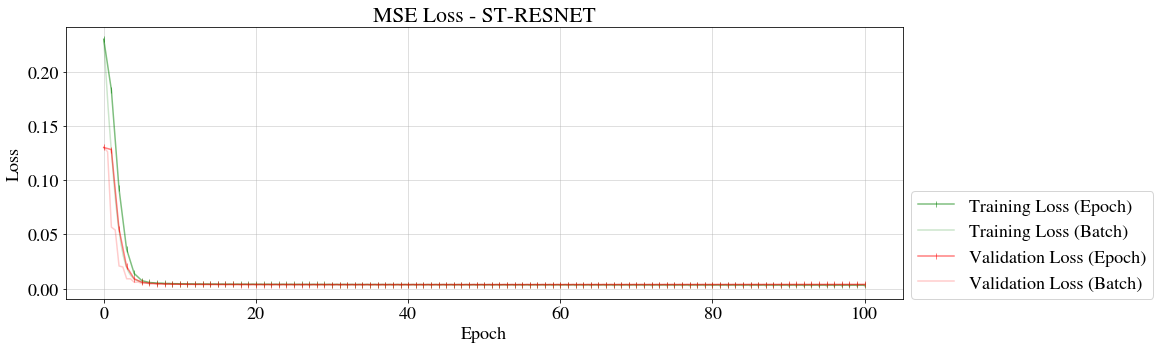

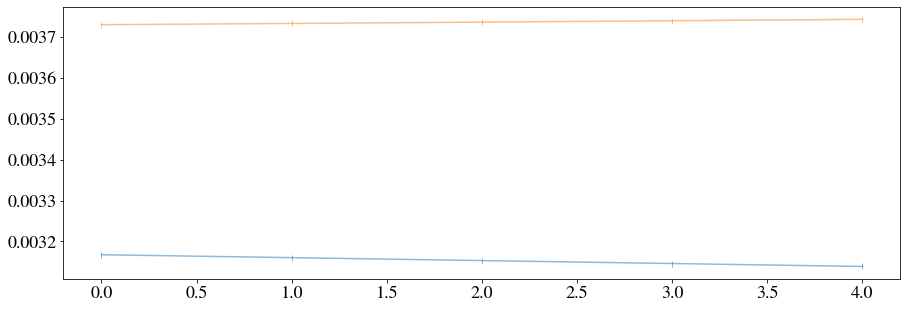

2019-12-03T18:47:45 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-12-03T18:47:45 | root | INFO | loading model from ./data/processed/T12H-X850M-Y880M_2013-01-01_2017-01-01/models/ST-RESNET/
2019-12-03T18:47:46 | root | INFO | f1_score: 0.5845017769902804 at index 467224, new threshold 0.0631944090127945
2019-12-03T18:47:48 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                MAE:                0.2853964669809454
                RMSE:               0.47711892593655414
                ROC AUC:            0.7584648444448532                
                Average Precision:  0.5441247885466745
                Precision:          0.4604808573644504
                Recall:             0.6775071967634015
                Accuracy:           0.6927606783919598
                MCC:                0.3421601028049626          
        
2019-12-03T18:47:48 | root | INFO | =====================================BEGIN=====================

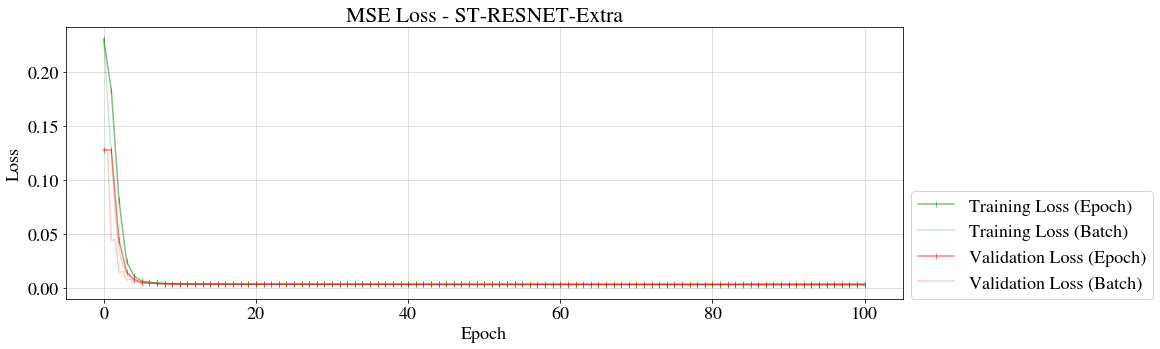

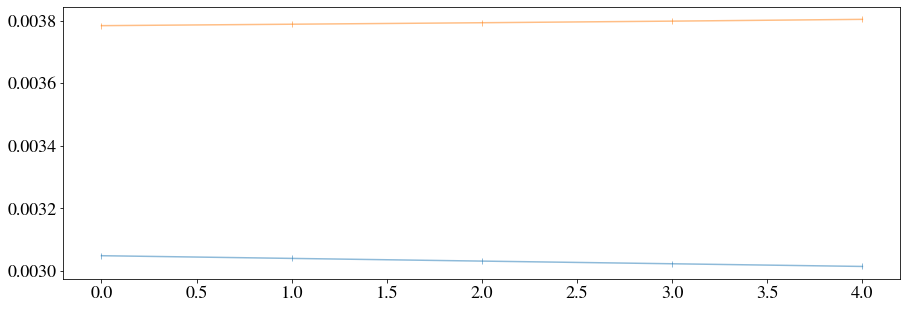

2019-12-03T18:52:05 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-12-03T18:52:05 | root | INFO | loading model from ./data/processed/T12H-X850M-Y880M_2013-01-01_2017-01-01/models/ST-RESNET-Extra/
2019-12-03T18:52:06 | root | INFO | f1_score: 0.5804389779481769 at index 500425, new threshold 0.06490666419267654
2019-12-03T18:52:08 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                MAE:                0.28467377326852306
                RMSE:               0.477443048968188
                ROC AUC:            0.7558589994745568                
                Average Precision:  0.5436233361007651
                Precision:          0.45980707395498394
                Recall:             0.6675484322726212
                Accuracy:           0.6926464709913203
                MCC:                0.33713142886412734          
        
2019-12-03T18:52:08 | root | INFO | 
                          RMSE       MAE  ...  A

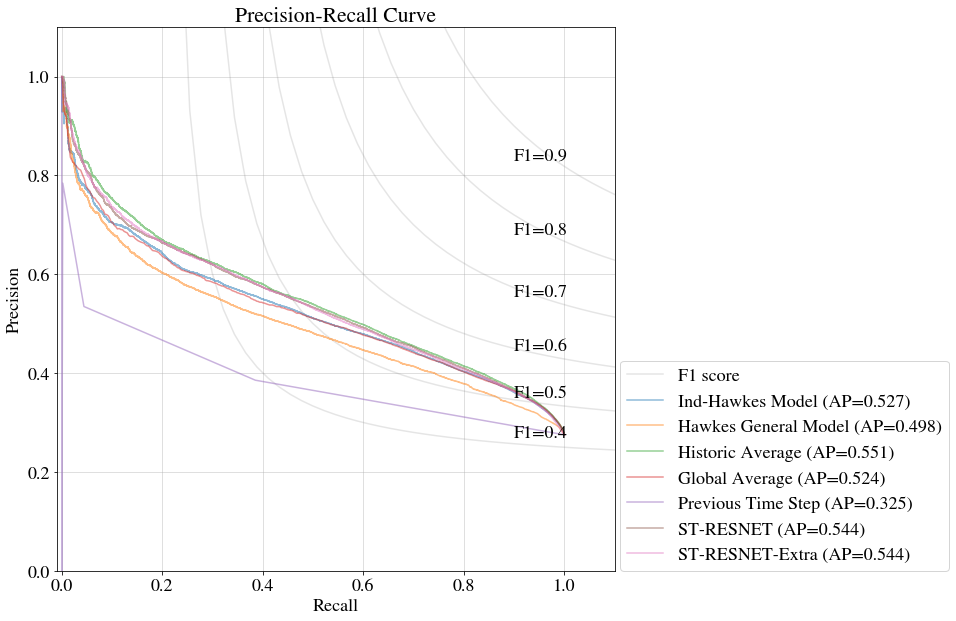

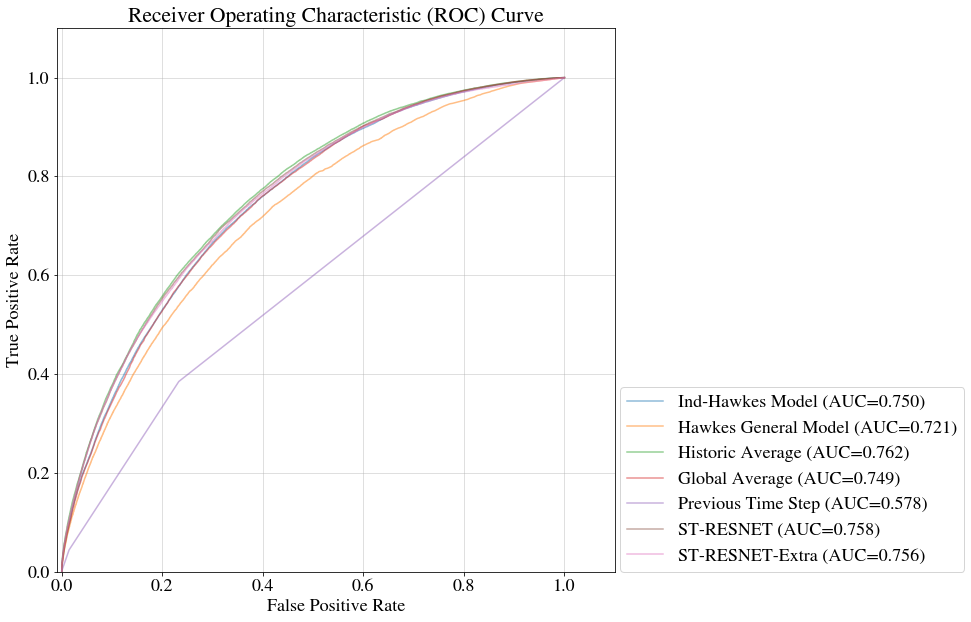

2019-12-03T18:52:09 | root | INFO | 
========================= T6H-X850M-Y880M_2013-01-01_2017-01-01 =========================

2019-12-03T18:52:09 | root | INFO | =====================================BEGIN=====================================
2019-12-03T18:52:09 | root | INFO | Device: cuda:0
2019-12-03T18:52:09 | root | INFO | 	t_range shape (5845,)
2019-12-03T18:52:10 | root | INFO | lr: 		0.0005
2019-12-03T18:52:10 | root | INFO | weight_decay: 	1e-08
2019-12-03T18:52:10 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-12-03T18:52:10 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T6H-X850M-Y880M_2013-01-01_2017-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '6H',
 'lr': 0.0005,
 'max_epochs': 100,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T6

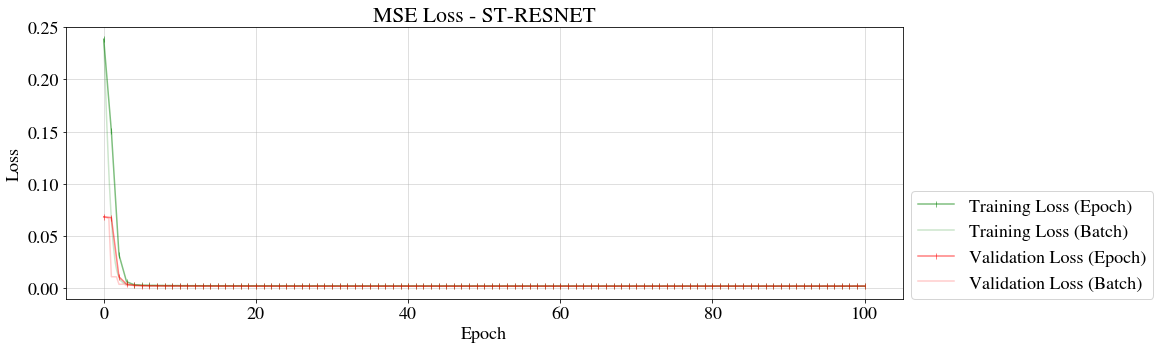

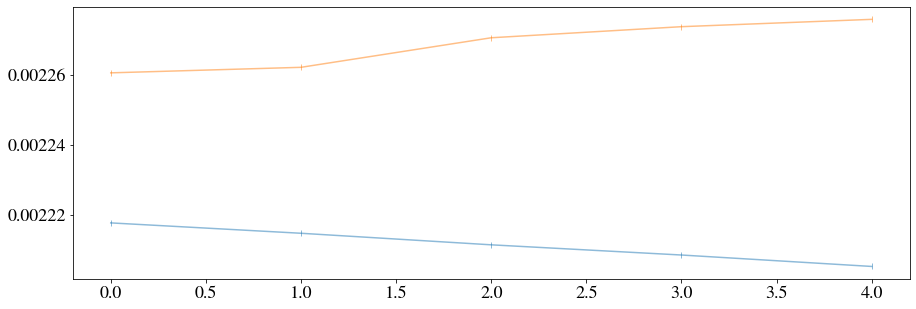

2019-12-03T18:58:46 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-12-03T18:58:46 | root | INFO | loading model from ./data/processed/T6H-X850M-Y880M_2013-01-01_2017-01-01/models/ST-RESNET/
2019-12-03T18:58:48 | root | INFO | f1_score: 0.4466575727547505 at index 958117, new threshold 0.04733430966734886
2019-12-03T18:58:52 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                MAE:                0.17480647872234586
                RMSE:               0.3761368878289359
                ROC AUC:            0.7466656415114046                
                Average Precision:  0.36434364640792316
                Precision:          0.3292165771719675
                Recall:             0.5381845191203943
                Accuracy:           0.7535137559808612
                MCC:                0.27681723875170505          
        
2019-12-03T18:58:52 | root | INFO | =====================================BEGIN===================

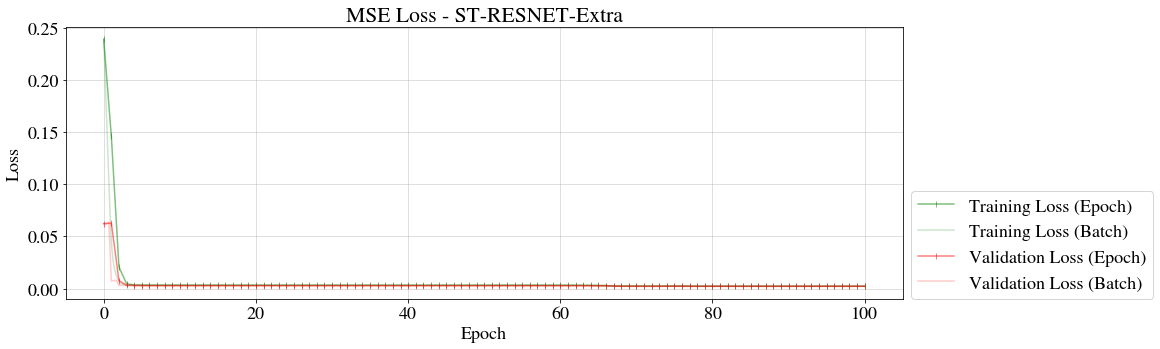

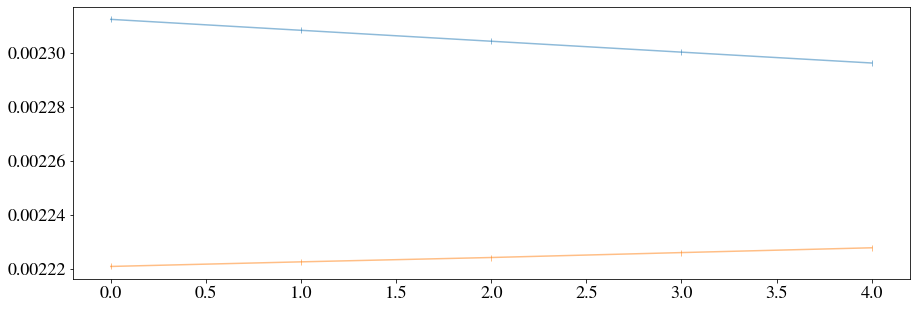

2019-12-03T19:06:12 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-12-03T19:06:12 | root | INFO | loading model from ./data/processed/T6H-X850M-Y880M_2013-01-01_2017-01-01/models/ST-RESNET-Extra/
2019-12-03T19:06:15 | root | INFO | f1_score: 0.4423206070984856 at index 929787, new threshold 0.04882432147860527
2019-12-03T19:06:18 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                MAE:                0.17449017330745784
                RMSE:               0.37629976559732764
                ROC AUC:            0.740342206196485                
                Average Precision:  0.36028645443660645
                Precision:          0.32766862129338853
                Recall:             0.5307569380359675
                Accuracy:           0.7535279961266803
                MCC:                0.2726210504019445          
        
2019-12-03T19:06:18 | root | INFO | 
                          RMSE       MAE  ...  A

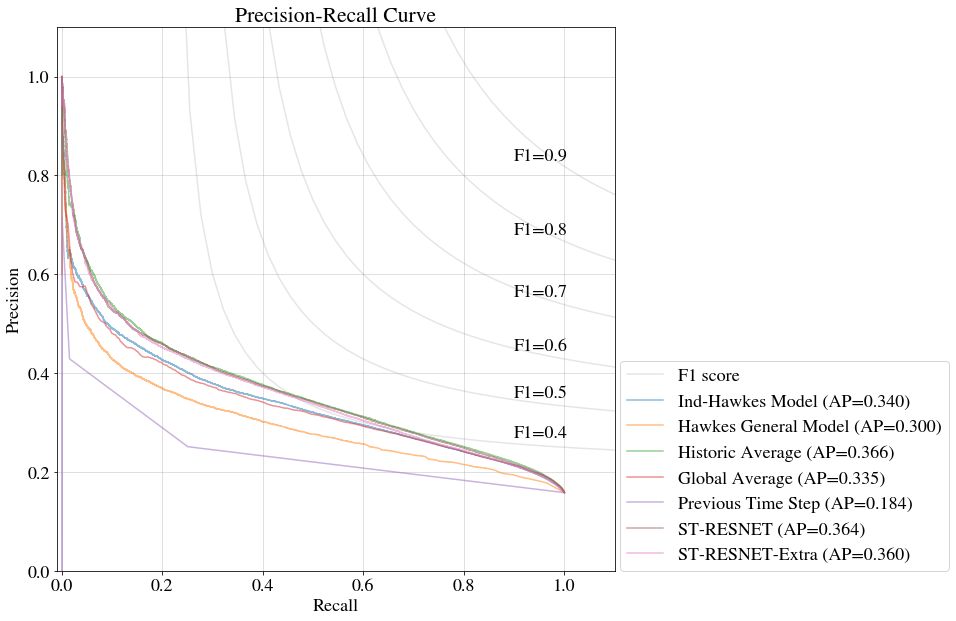

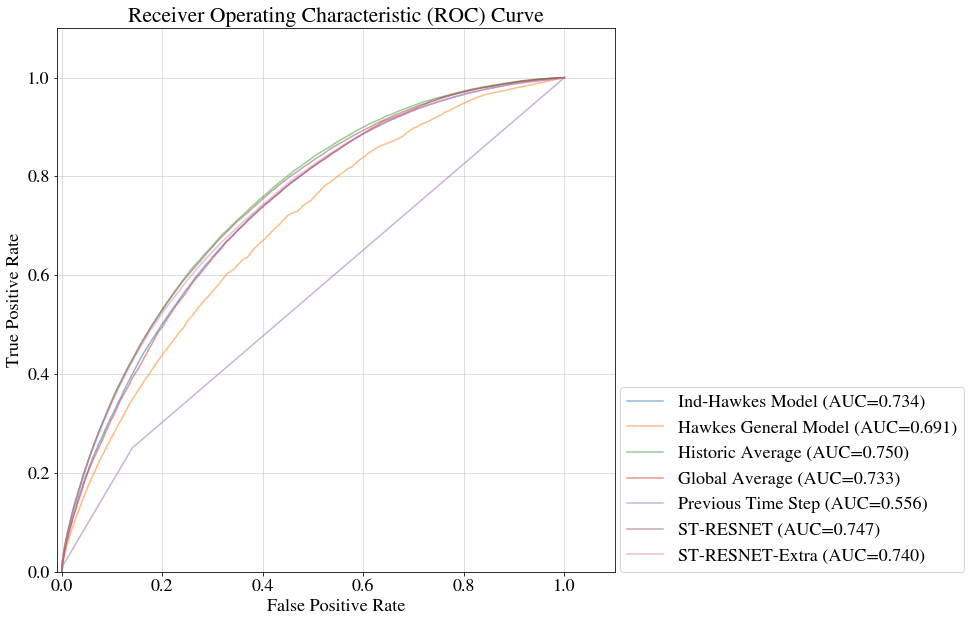

2019-12-03T19:06:20 | root | INFO | 
========================= T1H-X1700M-Y1760M_2013-01-01_2017-01-01 =========================

2019-12-03T19:06:20 | root | INFO | =====================================BEGIN=====================================
2019-12-03T19:06:20 | root | INFO | Device: cuda:0
2019-12-03T19:06:20 | root | INFO | 	t_range shape (35065,)
2019-12-03T19:06:21 | root | INFO | lr: 		0.0005
2019-12-03T19:06:21 | root | INFO | weight_decay: 	1e-08
2019-12-03T19:06:21 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-12-03T19:06:21 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2017-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.0005,
 'max_epochs': 100,
 'model_name': 'ST-RESNET',
 'model_path': './data/processe

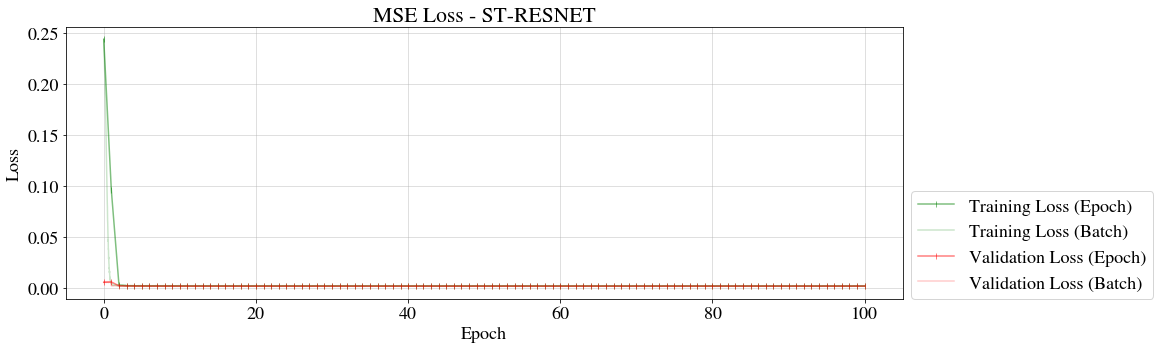

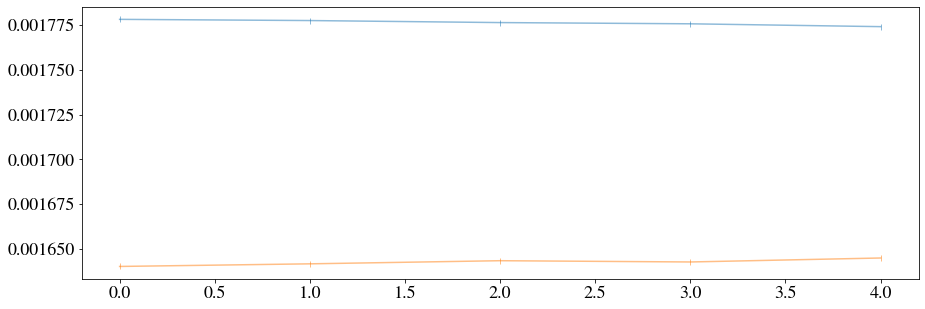

2019-12-03T19:33:59 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-12-03T19:33:59 | root | INFO | loading model from ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2017-01-01/models/ST-RESNET/
2019-12-03T19:34:06 | root | INFO | f1_score: 0.3415489319936979 at index 1275615, new threshold 0.03384760022163391


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-12-03T19:34:20 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                MAE:                0.11534455446504394
                RMSE:               0.30727408169777953
                ROC AUC:            0.7488135895688893                
                Average Precision:  0.2537775461581775
                Precision:          0.23194471865745311
                Recall:             0.5007779364436582
                Accuracy:           0.7813704760403191
                MCC:                0.22904510481981671          
        
2019-12-03T19:34:20 | root | INFO | =====================================BEGIN=====================================
2019-12-03T19:34:20 | root | INFO | Device: cuda:0
2019-12-03T19:34:20 | root | INFO | 	t_range shape (35065,)
2019-12-03T19:34:21 | root | INFO | lr: 		0.0005
2019-12-03T19:34:21 | root | INFO | weight_decay: 	1e-08
2019-12-03T19:34:21 | root | INFO | 
 ====================== Training ST-RESNET-Extra =========

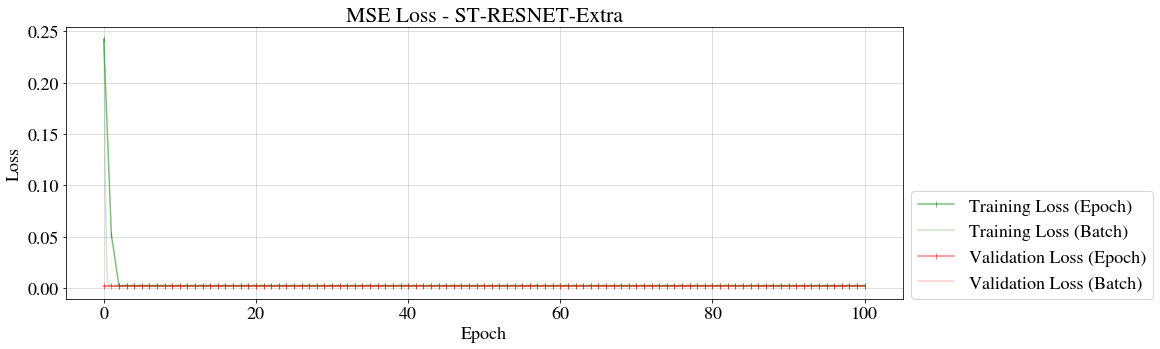

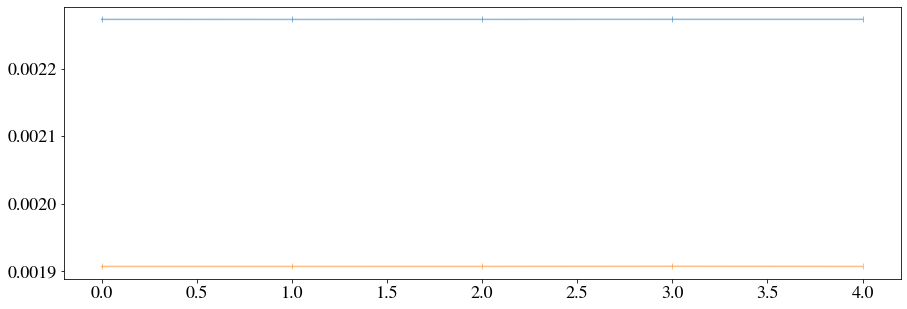

2019-12-03T20:04:45 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-12-03T20:04:45 | root | INFO | loading model from ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2017-01-01/models/ST-RESNET-Extra/
2019-12-03T20:04:52 | root | INFO | f1_score: 0.10301965883788342 at index 0, new threshold 0.0
2019-12-03T20:05:05 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                MAE:                0.10135286735114314
                RMSE:               0.3183309095882277
                ROC AUC:            0.4740075412564082                
                Average Precision:  0.0924169630889831
                Precision:          0.1013354009766591
                Recall:             1.0
                Accuracy:           0.1013354009766591
                MCC:                0.0          
        


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-12-03T20:05:06 | root | INFO | 
                          RMSE       MAE  ...  Accuracy  Matthews Corrcoef
Model Name                                ...                             
ST-RESNET             0.307274  0.115345  ...  0.781370           0.229045
Historic Average      0.307219  0.115530  ...  0.792826           0.225921
Ind-Hawkes Model      0.303955  0.120553  ...  0.772178           0.216239
Hawkes General Model  0.308475  0.115534  ...  0.755438           0.197643
Global Average        0.308343  0.116342  ...  0.747766           0.196177
Previous Time Step    0.312521  0.114004  ...  0.835627           0.097441
ST-RESNET-Extra       0.318331  0.101353  ...  0.101335           0.000000

[7 rows x 9 columns]


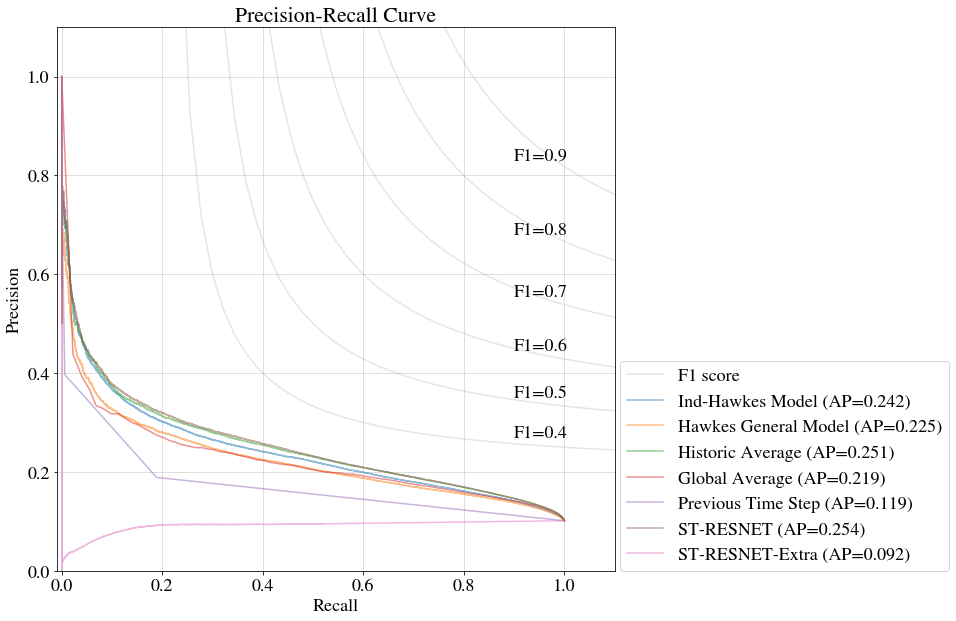

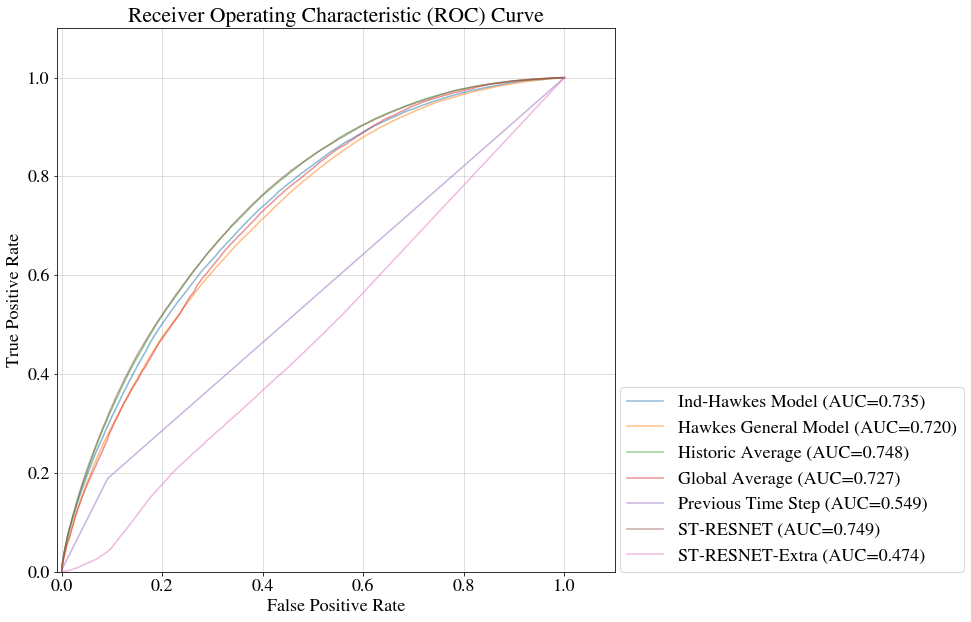

2019-12-03T20:05:07 | root | INFO | 
========================= T3H-X850M-Y880M_2013-01-01_2017-01-01 =========================

2019-12-03T20:05:07 | root | INFO | =====================================BEGIN=====================================
2019-12-03T20:05:07 | root | INFO | Device: cuda:0
2019-12-03T20:05:07 | root | INFO | 	t_range shape (11689,)
2019-12-03T20:05:09 | root | INFO | lr: 		0.0005
2019-12-03T20:05:09 | root | INFO | weight_decay: 	1e-08
2019-12-03T20:05:09 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-12-03T20:05:09 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T3H-X850M-Y880M_2013-01-01_2017-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '3H',
 'lr': 0.0005,
 'max_epochs': 100,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T

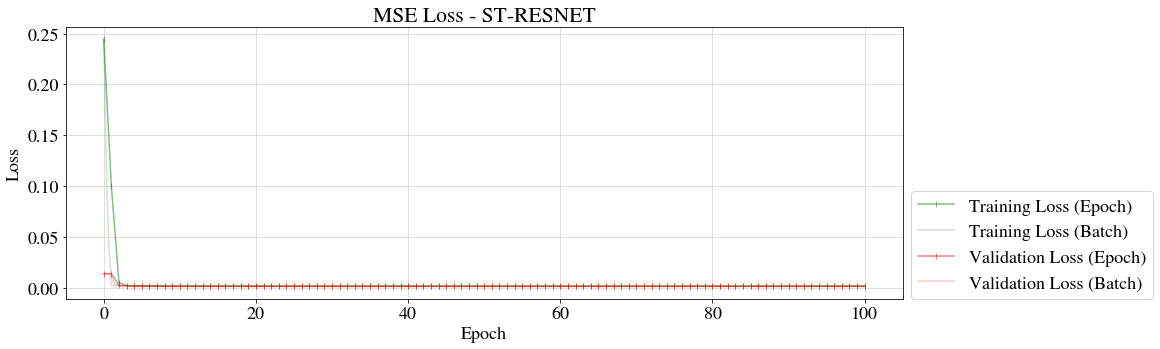

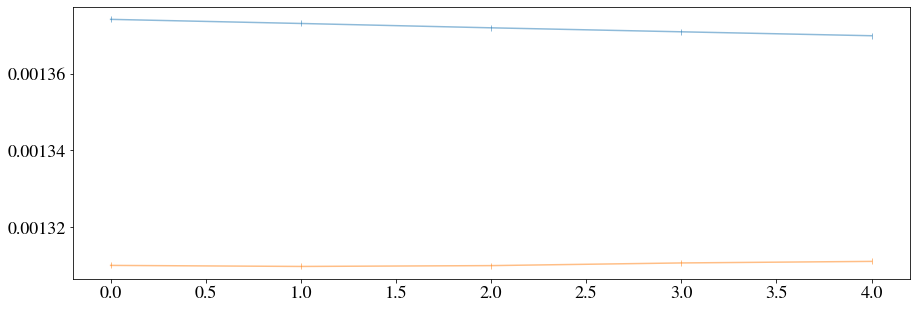

2019-12-03T20:17:02 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-12-03T20:17:02 | root | INFO | loading model from ./data/processed/T3H-X850M-Y880M_2013-01-01_2017-01-01/models/ST-RESNET/
2019-12-03T20:17:06 | root | INFO | f1_score: 0.31795655161109193 at index 1889103, new threshold 0.03378073498606682
2019-12-03T20:17:12 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                MAE:                0.09943724888911928
                RMSE:               0.28428928027623035
                ROC AUC:            0.7403907240837133                
                Average Precision:  0.22561037196007883
                Precision:          0.21940509915014164
                Recall:             0.41564151254953763
                Accuracy:           0.8223027363750143
                MCC:                0.2097596568104133          
        
2019-12-03T20:17:12 | root | INFO | =====================================BEGIN===============

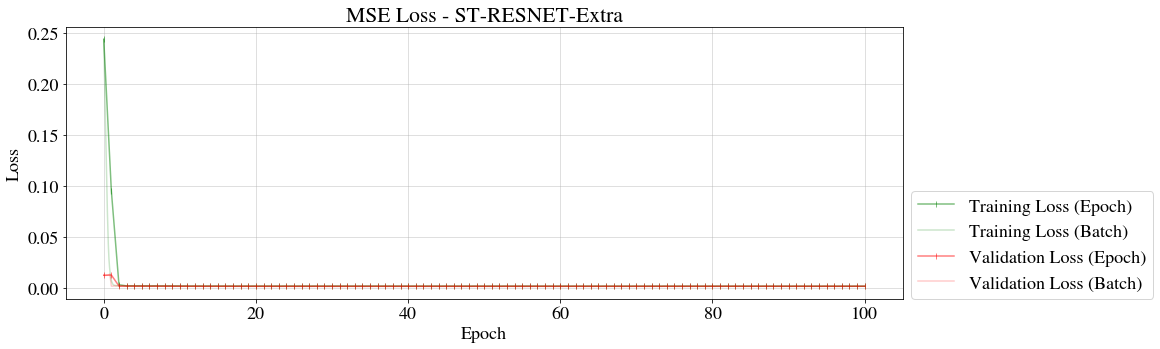

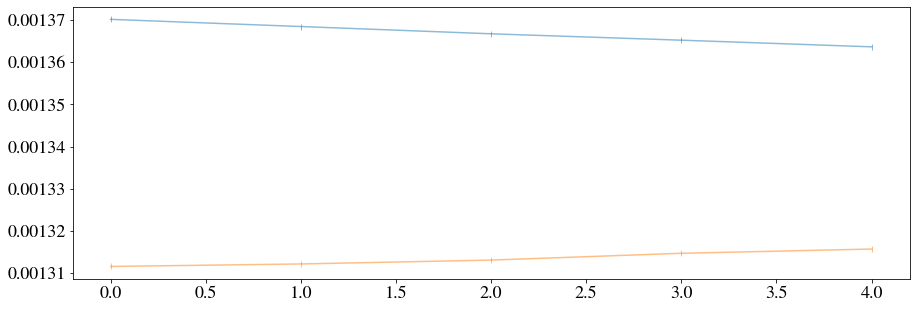

2019-12-03T20:30:18 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-12-03T20:30:18 | root | INFO | loading model from ./data/processed/T3H-X850M-Y880M_2013-01-01_2017-01-01/models/ST-RESNET-Extra/
2019-12-03T20:30:23 | root | INFO | f1_score: 0.31478890626285905 at index 2156621, new threshold 0.032691050320863724
2019-12-03T20:30:29 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                MAE:                0.0981206509152456
                RMSE:               0.2846072682702984
                ROC AUC:            0.7325798036515017                
                Average Precision:  0.22247349938374733
                Precision:          0.21592797631494953
                Recall:             0.40494963672391016
                Accuracy:           0.8220982904767323
                MCC:                0.2030609121256042          
        
2019-12-03T20:30:30 | root | INFO | 
                          RMSE       MAE  ...

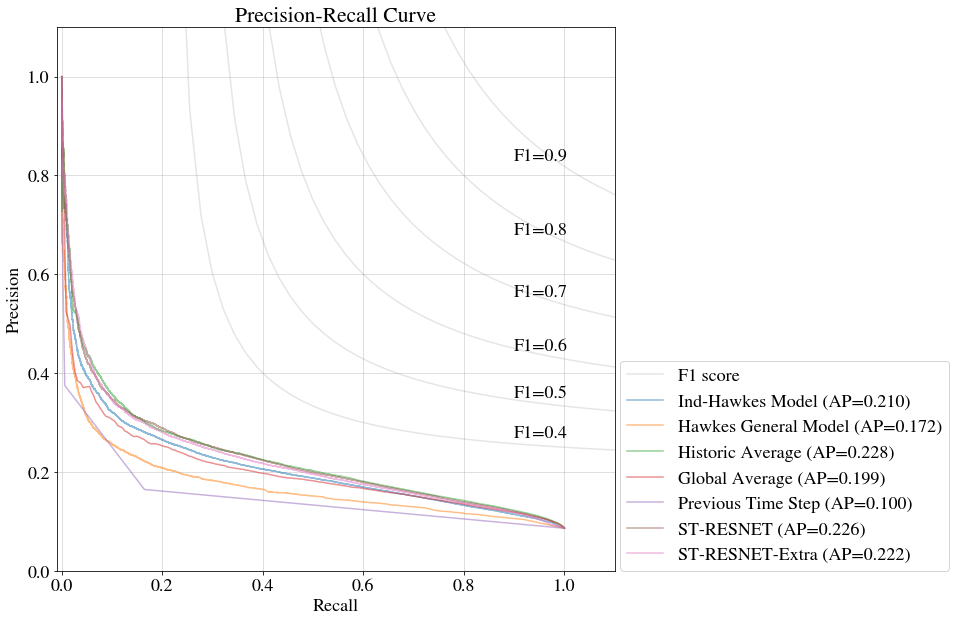

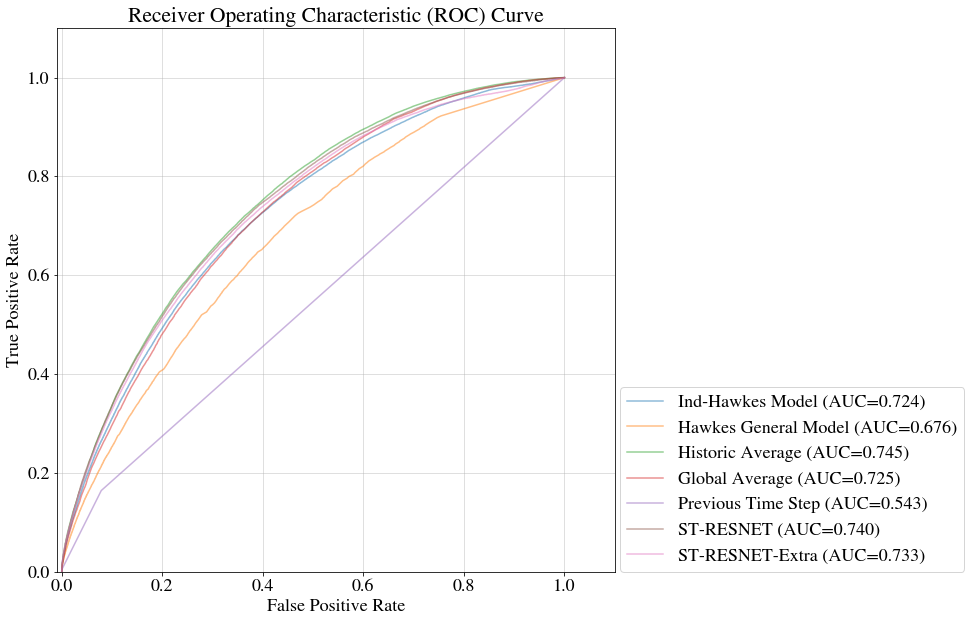

In [8]:
for data_sub_path in data_sub_paths:
    log.info(f"\n========================= {data_sub_path} =========================\n")
    for USE_EXTRA in [False, True]:

        conf = BaseConf()
        if USE_EXTRA:
            conf.model_name = "ST-RESNET-Extra"  # needs to be created
        else:
            conf.model_name = "ST-RESNET"  # needs to be created

        conf.data_path = f"./data/processed/{data_sub_path}/"

        if not os.path.exists(conf.data_path):
            raise Exception(f"Directory ({conf.data_path}) needs to exist.")

        conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
        os.makedirs(conf.data_path, exist_ok=True)
        os.makedirs(conf.model_path, exist_ok=True)

        # logging config is set globally thus we only need to call this in this file
        # imported function logs will follow the configuration
        setup_logging(save_dir=conf.model_path,
                      log_config='./logger/standard_logger_config.json',
                      default_level=log.INFO)
        log.info("=====================================BEGIN=====================================")

        info = deepcopy(conf.__dict__)
        info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

        # DATA LOADER SETUP
        np.random.seed(conf.seed)
        use_cuda = torch.cuda.is_available()
        if use_cuda:
            torch.cuda.manual_seed(conf.seed)
        else:
            torch.manual_seed(conf.seed)

        device = torch.device("cuda:0" if use_cuda else "cpu")
        log.info(f"Device: {device}")
        info["device"] = device.type
        conf.device = device

        conf.batch_size = 64  #32

        # CRIME DATA
        data_group = GridDataGroup(data_path=conf.data_path,
                                   conf=conf)

        loaders = GridDataLoaders(data_group=data_group,
                                  conf=conf)

        # SET THE hyperparameterS
        conf.dropout = 0  #0.2
        conf.weight_decay = 1e-8
        conf.lr = 5e-4
        conf.checkpoint = "best"  # "latest" #
        conf.resume = False
        conf.freqstr = DatetimeFreq.convert(data_group.t_range)
        conf.early_stopping = False
        conf.max_epochs = 100

        # SET LOSS FUNCTION
        # size averaged - so more epochs or larger lr for smaller batches
        loss_function = nn.MSELoss()

        # SETUP MODEL
        dataset = loaders.train_loader.dataset
        _, h_size, w_size = dataset.crimes.shape
        _, n_ext_features = dataset.time_vectors.shape

        # todo setup - hyper-optimiser
        conf.n_layers = 12  # number of res-unit layers
        conf.n_channels = 3  # inner channel size of the res-units

        if USE_EXTRA:
            train_epoch_fn = train_epoch_for_st_res_net_extra
            evaluate_fn = evaluate_st_res_net_extra
            model = STResNetExtra(n_layers=conf.n_layers,
                                  n_channels=conf.n_channels,
                                  y_size=h_size,
                                  x_size=w_size,

                                  lc=dataset.n_steps_c,
                                  lp=dataset.n_steps_p,
                                  lq=dataset.n_steps_q,

                                  n_ext_features=n_ext_features,
                                  n_demog_features=37,
                                  n_demog_channels=10,
                                  n_demog_layers=3,

                                  n_gsv_features=512,
                                  n_gsv_channels=10,
                                  n_gsv_layers=3)
        else:
            train_epoch_fn = train_epoch_for_st_res_net
            evaluate_fn = evaluate_st_res_net
            model = STResNet(n_layers=conf.n_layers,
                             n_channels=conf.n_channels,
                             y_size=h_size,
                             x_size=w_size,
                             lc=dataset.n_steps_c,
                             lp=dataset.n_steps_p,
                             lq=dataset.n_steps_q,
                             n_ext_features=n_ext_features)

            # todo implement model_arch for res-net
        model.to(conf.device)

        # SETUP OPTIMISER
        parameters = model.parameters()
        # todo (optional): setup model parameters dynamically 

        optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

        if conf.resume:
            try:
                # resume from previous check point or resume from best validation score checkpoint
                # load model state
                model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                              map_location=conf.device.type)
                model.load_state_dict(model_state_dict)

                # load optimiser state
                optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                                  map_location=conf.device.type)
                optimiser.load_state_dict(optimiser_state_dict)

                # new optimiser hyperparameters
                optimiser.param_groups[0]['lr'] = conf.lr
                optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

            except Exception as e:
                log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

        log.info(f"lr: \t\t{optimiser.param_groups[0]['lr']}")
        log.info(f"weight_decay: \t{optimiser.param_groups[0]['weight_decay']}")
        trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                                        optimiser=optimiser,
                                                                        loaders=loaders,
                                                                        train_epoch_fn=train_epoch_fn,
                                                                        loss_fn=loss_function,
                                                                        conf=conf)

        log.info(f"stopped_early: {stopped_early}")  # use the current epoch instead
        # if stopped_early -> continue with best_model - new hyperparameters -> no n

        lim = 10
        plt.figure(figsize=(15, 5))
        plt.title(f"Last {lim} epochs losses")
        plt.plot(trn_epoch_losses[-lim:], marker='|', alpha=.5, label="train")
        plt.plot(val_epoch_losses[-lim:], marker='|', alpha=.5, label="val")
        plt.show()

        plt.figure(figsize=(15, 5))
        plt.title(f"Last {lim} epochs diff(losses) ")
        plt.plot(np.diff(trn_epoch_losses[-lim:]), marker='|', alpha=.5, label="train")
        plt.plot(np.diff(val_epoch_losses[-lim:]), marker='|', alpha=.5, label="val")
        plt.show()

        # Load latest or best validation model
        # conf.checkpoint = "latest"
        conf.checkpoint = "best"

        log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

        # resume from previous check point or resume from best validation score checkpoint
        # load model state
        log.info(f"loading model from {conf.model_path}")
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)

        trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                             batch_loader=loaders.train_loader,
                                                                             conf=conf)
        thresh = best_threshold(trn_y_true, trn_probas_pred)

        tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                                             batch_loader=loaders.test_loader,
                                                                             conf=conf)

        tst_y_true = np.expand_dims(tst_y_true, axis=1)
        tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)

        tst_y_true = data_group.shaper.squeeze(tst_y_true)
        tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)

        tst_y_pred = get_y_pred(thresh, tst_probas_pred)
        save_metrics(y_count=tst_y_true,
                     y_pred=tst_y_pred,
                     y_score=tst_probas_pred,
                     t_range=tst_t_range,
                     shaper=data_group.shaper,
                     conf=conf)
    compare_all_models(data_path=conf.data_path)

In [0]:
for data_sub_path in get_data_sub_paths():
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    models_metrics = get_models_metrics(data_path)
    metrics_table = get_metrics_table(models_metrics)
    print(metrics_table)
    print("\n===================================================================================================\n")